In [1]:
# Install required package
import sys
!{sys.executable} -m pip install --user --upgrade steam-nb-api

import os
from pathlib import Path
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from copy import *
from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

# Global variables

In [2]:
nameMagnet = 'MBX'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}

# If this variable is set to True, many comments will be displayed
verbose = True

# Generate magnet geometry parsing .data and .cadata files

VERSION 10.2.1
'MBX 1.9K D1 SEPARATION DIPOLE IN IP2 (ALICE) AND IP8 (LHCb) NB: Meas and model 4.5K'
'../datab/roxie.bhdata                                                              '
'../datab/roxie.cadata                                                              '
'MBX_2D.iron                                                                        '

&OPTION
  LEND=F     LWEDG=F    LPERS=F    LQUENCH=F  LALGO=F    LQUENCH0D=F
  LMIRIRON=F LBEMFEM=T  LPSI=F     LSOLV=F    LIRON=T    LMORPH=F   
  LHARD=F    LPOSTP=F   LPEAK=T    LINMARG=F  LMARG=F    LSELF=T    
  LMQE=F     LINDU=F    LEDDY=F    LSOLE=F    LFLUX=F    LFIELD3=F  
  LFISTR=F   LSELF3=F   LBRICK=F   LLEAD=F    LVRML=F    LOPERA=F   
  LOPER20=F  LANSYS=F   LRX2ANS=F  LANS2RX=F  LDXF=F     LMAP2D=T   
  LMAP3D=F   LEXPR=F    LFIL3D=F   LFIL2D=F   LCNC=F     LANSYSCN=F 
  LWEIRON=F  LCATIA=F   LEXEL=T    LQVOLT=F   LAXIS=T    LIMAGX=F   
  LIMAGY=F   LRAEND=F   LMARKER=F  LROLER2=F  LROLERP=F  LIMAGZZ=F  
  LSUPP=F  

<IPython.core.display.Javascript object>


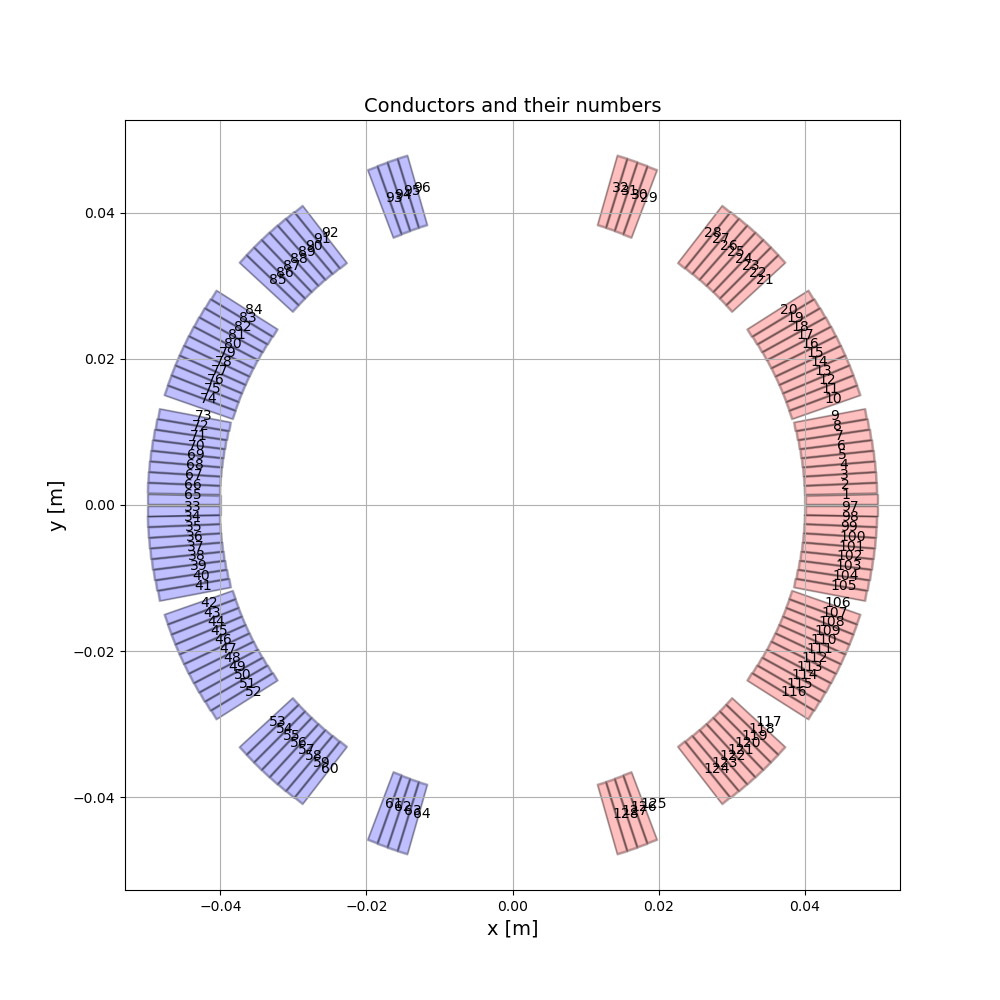

In [3]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'

# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)

# Plot conductors and their numbers
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()


# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 3840
Peak magnetic field in the field-map from ROXIE = 4.610642646096094 T


<IPython.core.display.Javascript object>


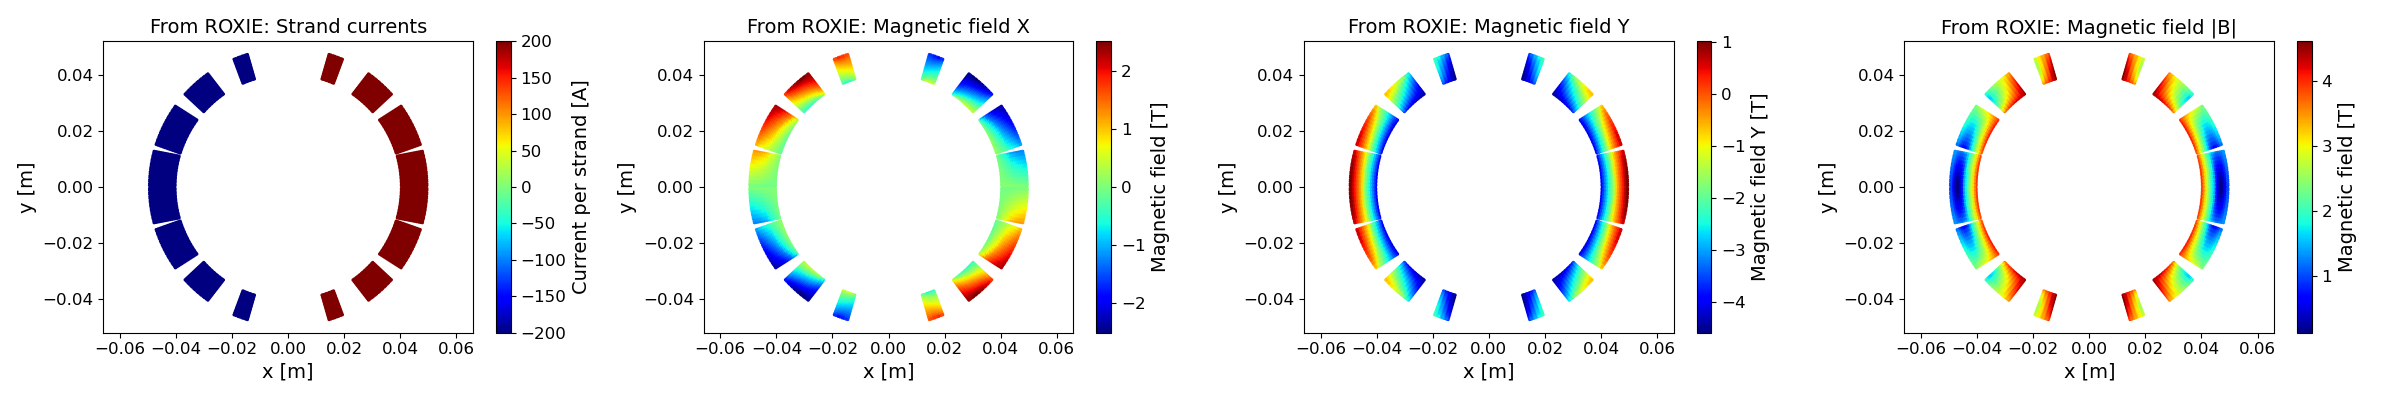

In [4]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_NoIron_NoSelfField.map2d'
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
#         print(index)
#         print(row)
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])
        
[_,c] = np.unique(strandToHalfTurn,return_index=True)
[_,nT] = np.unique(strandToGroup[c],return_counts=True) 

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = {}'.format(nStrandsFieldMap))

# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])
print('Peak magnetic field in the field-map from ROXIE = {} T'.format(np.max(B)))

# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()


<IPython.core.display.Javascript object>


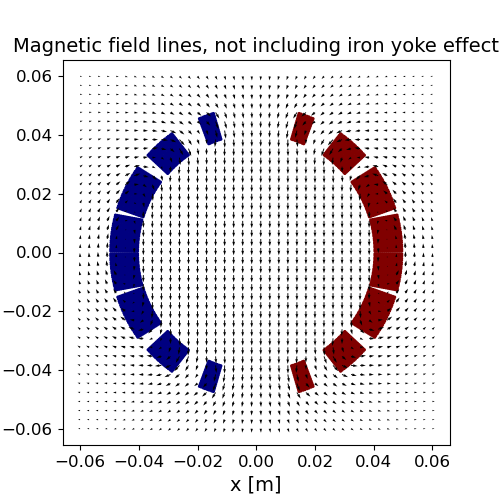

(-0.066, 0.066, -0.066, 0.066)

In [5]:
minMaxX = [-0.06, 0.06] # to adjust depending on the coil dimensions
minMaxY = [-0.06, 0.06] # to adjust depending on the coil dimensions
nGridPoints=[40, 40]
Bx_map, By_map, B_map, x_map, y_map = definedMagneticCoil.calculateMagneticFieldGrid(minMaxX, minMaxY, nGridPoints)

# Plot current lines
f = plt.figure(figsize=(5, 5))
plt.scatter(xS, yS, s=2, c=iS)
# Plot magnetic field arrows
q = plt.quiver(x_map, y_map, Bx_map, By_map, color='k')
plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Magnetic field lines, not including iron yoke effect', **selectedFont)
plt.set_cmap('jet')
# cbar = plt.colorbar()
# cbar.set_label('Magnetic field [T]', **selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Manipulate imported strand positions

Total number of strands = 3840
Total number of half-turns = 128
Total number of turns = 64
Total number of groups = 16


<IPython.core.display.Javascript object>


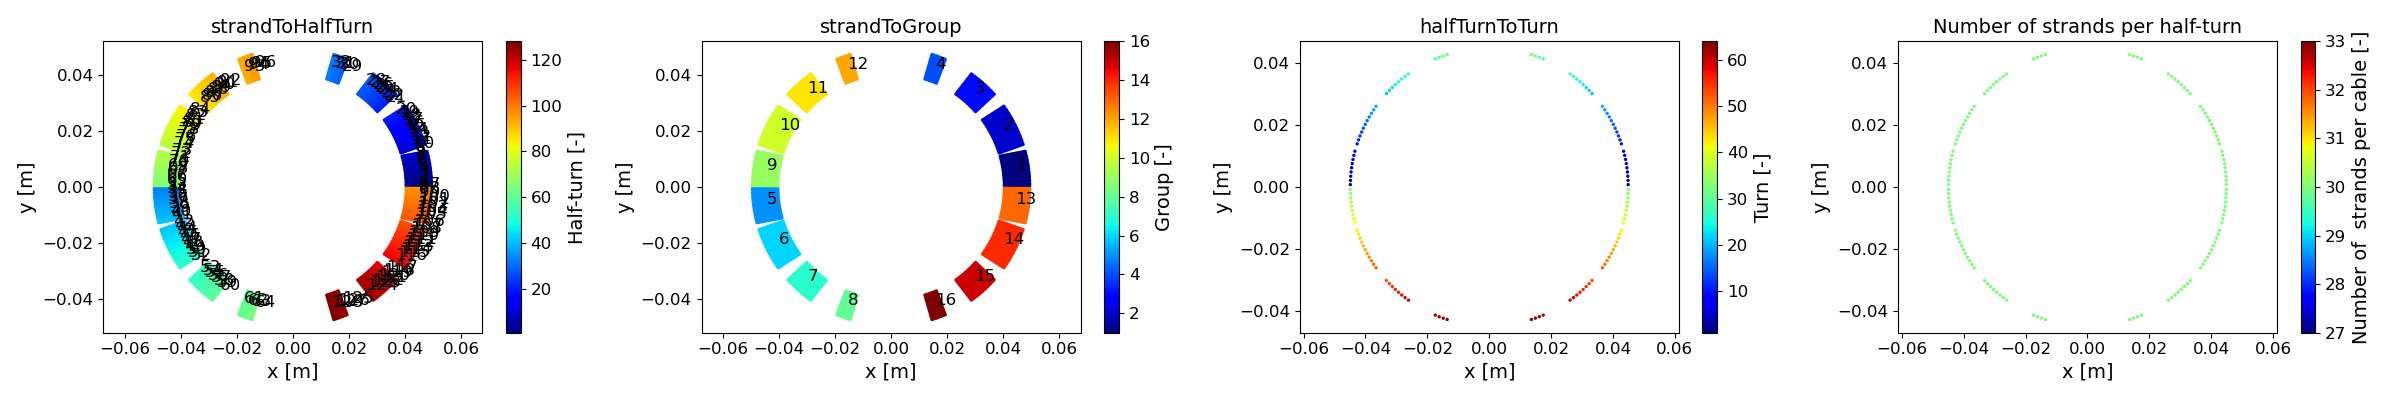

In [6]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Overall magnet variables

In [7]:
T00 = 1.9
l_magnet = 9.45
# Current to be simulated
I00 = 5750
# Reference current from ROXIE
Iref = 6000

# Definition of groups of conductors

1 coil sections defined.
16 groups defined.


<IPython.core.display.Javascript object>


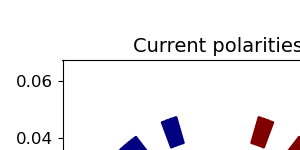

(-0.05436706, 0.05436706, -0.05195564, 0.05195564)

In [8]:
GroupToCoilSection = nGroups * [1]
polarities_inGroup = 4* [+1] + 4* [-1] + 4* [-1] + 4* [+1]

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')


# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]
    

f = plt.figure(figsize=(5,5))
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Current polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Conductor properties in each group

In [9]:
# Number of half-quadrants
nHalfQuadrants = 4
nGroupsPerQuadrant = 4

# Number of strands in each cable belonging to a particular group
nStrands_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [30]
# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [l_magnet]
# strand diameter [m]
ds_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0.6477E-3]
# filament diameter [m]
df_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [6E-6]
# fraction of superconductor in the strands
f_SC_strand_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1/(1+1.8)]
# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# Filament twist-pitch [m]
Lp_f_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0.013]
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [140]
# type of superconductor (1=Nb-Ti, 2=Nb3Sn(Summer's fit), 3=BSCCO2212, 4=Nb3Sn(Bordini's fit))
SCtype_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [2]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [2]
# Type of filler of voids between strands and insulation layers (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [2]
# bare cable width [m]
wBare_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [9.70E-3]
# bare average cable height [m]
hBare_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [(1.061E-3+1.271E-3)/2]
# insulation thickness in the width direction [m]
wIns_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [100E-6]
# insulation thickness in the height direction [m]
hIns_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [180E-6]
# Strand twist-pitch [m]
Lp_s_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [74E-3]
# Cross-contact resistance [Ohm]
R_c_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [100E-6]
# Tc0_NbTi_ht_inGroup [K]
Tc0_NbTi_ht_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [9.2]
# Bc2_NbTi_ht_inGroup [T]
Bc2_NbTi_ht_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [14.5]
# c1_Ic_NbTi_inGroup [A]
c1_Ic_NbTi_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [34404.9]
# c2_Ic_NbTi_inGroup [A/T]
c2_Ic_NbTi_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [-2566.9]
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]
# Jc_Nb3Sn0 [A*T^0.5/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [0]

# Jc fit parameters - Based on Arjan's file 
fitParameters_inGroup = np.array([[9.2, 14.5, 1181.9, -89.7, 3291.7, 1.4, 13081.8, 12.0]] * nHalfQuadrants * nGroupsPerQuadrant).transpose() 
# Jc fit type (only used for persistent-current calculation): 1= Jc=constant; 2= Nb-Ti Bottura; 3= Nb-Ti CUDI ; 4= Nb3Sn Summer
selectedFit_inGroup = nHalfQuadrants * nGroupsPerQuadrant * [3]

nHalfTurnsDefined = np.sum(nT)
print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 500E-6
insulationAroundCables = 150E-6
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

128 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
0.375


# Electrical order of the half-turns

The half-turns of these pairs of groups will be connected electrically:
[[1, 9], [2, 10], [3, 11], [4, 12], [5, 13], [6, 14], [7, 15], [8, 16]]


<IPython.core.display.Javascript object>


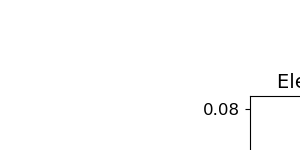

Calculated electrical order of the half-turns:
el_order_half_turns = [1, 65, 2, 66, 3, 67, 4, 68, 5, 69, 6, 70, 7, 71, 8, 72, 9, 73, 10, 74, 11, 75, 12, 76, 13, 77, 14, 78, 15, 79, 16, 80, 17, 81, 18, 82, 19, 83, 20, 84, 21, 85, 22, 86, 23, 87, 24, 88, 25, 89, 26, 90, 27, 91, 28, 92, 29, 93, 30, 94, 31, 95, 32, 96, 33, 97, 34, 98, 35, 99, 36, 100, 37, 101, 38, 102, 39, 103, 40, 104, 41, 105, 42, 106, 43, 107, 44, 108, 45, 109, 46, 110, 47, 111, 48, 112, 49, 113, 50, 114, 51, 115, 52, 116, 53, 117, 54, 118, 55, 119, 56, 120, 57, 121, 58, 122, 59, 123, 60, 124, 61, 125, 62, 126, 63, 127, 64, 128]


In [10]:
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
#     el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether = [ [1,9], [2,10], [3,11], [4,12], [5,13], [6,14], [7,15], [8,16] ]
# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder = [ 0, 0, 0, 0, 0, 0, 0, 0 ]

nElPairs=len(elPairs_GroupTogether);

print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)


# Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,1]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = ' + str(el_order_half_turns))

# Cable geometry parameters (NOT DONE AUTOMATICALLY - PLACEHOLDER)

<IPython.core.display.Javascript object>


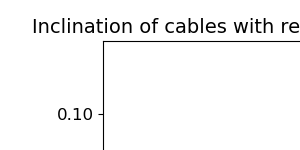

In [11]:
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
alphasDEG = nHalfQuadrants * [0, 1.2404, 2.4808, 3.7212, 4.9616, 6.202, 7.4424, 8.6828, 9.9232, 19.2559, 20.4963, 21.7367, 22.9771, 24.2175, 25.4579, 26.6983, 27.9387, 29.1791, 30.4195, 31.6599, 42.7028, 43.9432, 45.1836, 46.424, 47.6644, 48.9048, 50.1452, 51.3856, 69.2946, 70.535, 71.7754, 73.0158 ]
# Rotate cable by a certain angle [deg]
rotation_block = int(nHalfTurnsDefined/4) * [0] + int(nHalfTurnsDefined/4) * [180] + int(nHalfTurnsDefined/4) * [90] + int(nHalfTurnsDefined/4) * [270]
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
mirror_block = int(nHalfTurnsDefined/2) * [0] + int(nHalfTurnsDefined/2) * [1]
# Mirror cable along the Y axis (0=no, 1=yes)
mirrorY_block = nHalfTurnsDefined * [0]

# Plot
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 4, 1)
plt.scatter(x_ave, y_ave, s=2, c=alphasDEG)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Inclination of cables with respect to X-axis',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('$\\alpha$ [deg]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=rotation_block)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Block rotation',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('$\\alpha$ [$\\circ$]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=mirror_block)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Mirror cable along the bisector of its quadrant',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Mirroring  [(0=no, 1=yes)]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
# Plot
plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=mirrorY_block)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Mirror cable along the Y axis',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Mirroring [(0=no, 1=yes)]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

fig.tight_layout()

# Heat exchange between half-turns along the cable wide side

In [12]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )
    
#Add_Con_From = [41, 52, 60, 105, 116, 124, 73, 84, 92, 9, 20, 28]
#Add_Con_To = [42, 53, 61, 106, 117, 125, 74, 85, 93, 10, 21, 29]

#for i in range(len(Add_Con_From)):
#    iContactAlongWidth_From.append(Add_Con_From[i])
 #   iContactAlongWidth_To.append(Add_Con_To[i])

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127]
iContactAlongWidth_To = 
[2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118

# Heat exchange between half-turns along the cable narrow side

Heat exchange along the cable narrow side - Calculated indices:
iContactAlongHeight_From = 
[1]
iContactAlongWidth_To = 
[1]


<IPython.core.display.Javascript object>


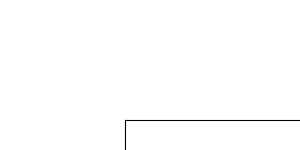

(-0.05503286306217601,
 0.05503286306217601,
 -0.052706765435317195,
 0.05270676543531719)

In [13]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = 0.5E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])
#Keep arrays Non-empty
iContactAlongHeight_From.append(1)
iContactAlongHeight_To.append(1)

# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
print(iContactAlongHeight_To)


# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=2, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# Quench initiation calculation: Force selected half-turns to quench

In [14]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = [1]
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
vQ_iStartQuench = [9999]

# Electrical circuit during powering transient
<img src="../resources/LEDET_CircuitSchematic_Powering.png" width="750"/>


# Electrical circuit during protection transient
<img src="../resources/LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [15]:
# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 0.000
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.000
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.000

# Power supply control

<IPython.core.display.Javascript object>


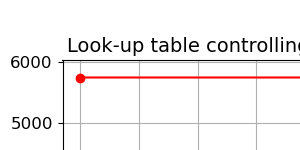

In [16]:
# Time when the power supply is switched off and the crowbar is switched on [s]
t_PC = 0
tStart = -0.02
# LUT controlling power supply, Time [s]
t_PC_LUT = [tStart, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.figure(figsize=(5,5))
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Energy-extraction system

In [17]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.066

# CLIQ system

In [18]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1]
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.05

# Quench heater parameters

## BNL Design

In [19]:
# Number of quench heater strips to write in the file
nHeaterStrips = 4
# Number of QH circuits
nQHcircuits = 2

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStrips * [.002]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStrips * [900/nQHcircuits]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStrips * [7.05E-3*nQHcircuits]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStrips * [0.25* nQHcircuits] # 0.25-->0.28 Ohm partially compensates the fact that the real strip is 9.646 m long instead of l_magnet=9.450 m long
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStrips * [44.45E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStrips * [0.0254E-3]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStrips * [75E-6] 
# Type of material of the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStrips * [2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStrips * [500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStrips * [2]
# Length of the QH strip.
l_QH = nHeaterStrips * [10.16]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStrips * [.127/(.127+.635)]


############################################################################################################
# The following lines do not affect the generated LEDET input file, and are only used to debug this notebook
# Calculate QH strip resistance
rhoSS = 5.00E-07 * 1.09 # in [Ohm m]
R_cold_QH, R_total_QH, I0_QH, tau_QH = [], [], [], []
for qh in range(len(tQH)):
    R_cold_QH.append(rhoSS / (w_QH[qh] * h_QH[qh]) * l_QH[qh] * f_QH[qh])
    R_total_QH.append(R_cold_QH[qh] + R_warm_QH[qh])
    I0_QH.append(U0_QH[qh] / R_total_QH[qh])
    tau_QH.append(R_total_QH[qh] * C_QH[qh])

print('I0_QH={}'.format(I0_QH))
print('tau_QH={}'.format(tau_QH))

I0_QH=[341.58246762487556, 341.58246762487556, 341.58246762487556, 341.58246762487556]
tau_QH=[0.018575309336332956, 0.018575309336332956, 0.018575309336332956, 0.018575309336332956]


## CERN design

In [20]:
# Number of quench heater strips to write in the file
nHeaterStrips = 4
# Number of QH circuits
nQHcircuits = 2

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStrips * [.002]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStrips * [900/nQHcircuits]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStrips * [7.05E-3*nQHcircuits]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStrips * [0.25* nQHcircuits] # 0.25-->0.28 Ohm partially compensates the fact that the real strip is 9.646 m long instead of l_magnet=9.450 m long
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStrips * [15E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStrips * [0.025E-3]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStrips * [75E-6] 
# Type of material of the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStrips * [2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStrips * [500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStrips * [2]
# Length of the QH strip.
l_QH = nHeaterStrips * [9.646]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStrips * [.1/(.1+.2)]


############################################################################################################
# The following lines do not affect the generated LEDET input file, and are only used to debug this notebook
# Calculate QH strip resistance
rhoSS = 5.00E-07 * 1.09 # in [Ohm m]
R_cold_QH, R_total_QH, I0_QH, tau_QH = [], [], [], []
for qh in range(len(tQH)):
    R_cold_QH.append(rhoSS / (w_QH[qh] * h_QH[qh]) * l_QH[qh] * f_QH[qh])
    R_total_QH.append(R_cold_QH[qh] + R_warm_QH[qh])
    I0_QH.append(U0_QH[qh] / R_total_QH[qh])
    tau_QH.append(R_total_QH[qh] * C_QH[qh])

print('I0_QH={}'.format(I0_QH))
print('tau_QH={}'.format(tau_QH))

I0_QH=[86.9909632498621, 86.9909632498621, 86.9909632498621, 86.9909632498621]
tau_QH=[0.07293861066666667, 0.07293861066666667, 0.07293861066666667, 0.07293861066666667]


## Modified CERN/BNL design

In [21]:
# Number of quench heater strips to write in the file
nHeaterStrips = 8
# Number of QH circuits
nQHcircuits = 2

# Time at which the power supply connected to the QH strip is triggered (Low-field QHs set to a very large value to avoid triggering).
tQH = nHeaterStrips * [.002]
# Charging voltage of the capacitor connected to the QH strip.
U0_QH = nHeaterStrips * [900/nQHcircuits]
# Capacitance of the capacitor connected to the QH strip.
C_QH = nHeaterStrips * [7.05E-3*nQHcircuits]
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = nHeaterStrips * [0.2* nQHcircuits] # 0.25-->0.28 Ohm partially compensates the fact that the real strip is 9.646 m long instead of l_magnet=9.450 m long
# Width of the non-Cu-plated part of the the QH strip.
w_QH = nHeaterStrips * [15E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = nHeaterStrips * [0.025E-3]
# Thickness of the insulation layer between QH strip and coil insulation layer.
s_ins_QH = nHeaterStrips * [75E-6] 
# Type of materialof the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = nHeaterStrips * [2]
# Thickness of the insulation layer between QH strip and the helium bath (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = nHeaterStrips * [500E-6]
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = nHeaterStrips * [2]
# Length of the QH strip.
l_QH = nHeaterStrips * [l_magnet]
# Fraction of QH strip covered by heating stations (not-Cu-plated).
f_QH = nHeaterStrips * [.127/(.127+.633)]


############################################################################################################
# The following lines do not affect the generated LEDET input file, and are only used to debug this notebook
# Calculate QH strip resistance
rhoSS = 5.00E-07 * 1.09 # in [Ohm m]
R_cold_QH, R_total_QH, I0_QH, tau_QH = [], [], [], []
for qh in range(len(tQH)):
    R_cold_QH.append(rhoSS / (w_QH[qh] * h_QH[qh]) * l_QH[qh] * f_QH[qh])
    R_total_QH.append(R_cold_QH[qh] + R_warm_QH[qh])
    I0_QH.append(U0_QH[qh] / R_total_QH[qh])
    tau_QH.append(R_total_QH[qh] * C_QH[qh])

print('I0_QH={}'.format(I0_QH))
print('tau_QH={}'.format(tau_QH))

I0_QH=[166.9744138563376, 166.9744138563376, 166.9744138563376, 166.9744138563376, 166.9744138563376, 166.9744138563376, 166.9744138563376, 166.9744138563376]
tau_QH=[0.03799983394736841, 0.03799983394736841, 0.03799983394736841, 0.03799983394736841, 0.03799983394736841, 0.03799983394736841, 0.03799983394736841, 0.03799983394736841]


# Heat exchange between quench heater strips and half-turns - QH POSITIONS ONLY GUESSED

<IPython.core.display.Javascript object>


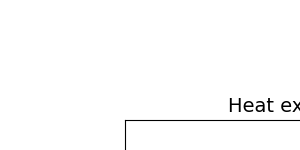

iQH_toHalfTurn_From = [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]
iQH_toHalfTurn_To = [1, 2, 3, 4, 5, 6, 7, 8, 33, 34, 35, 36, 37, 38, 39, 40, 65, 66, 67, 68, 69, 70, 71, 72, 97, 98, 99, 100, 101, 102, 103, 104]


In [22]:
# Thermal connections between heater strips and half-turns are manually defined for one half-quadrant and then automatically extended to the other half-quadrants
iQH_toHalfTurn_From_oneHalfQuadrant = [1,1,1,1,1,1,1,1]
iQH_toHalfTurn_To_oneHalfQuadrant = [1,2,3,4,5,6,7,8]

nHalfTurnsinHQ = sum(nT[0:4])


# Automatically extend to the other half-quadrants
iQH_toHalfTurn_To=[]
iQH_toHalfTurn_From=[]
for i in range (0,nHalfQuadrants):
    iQH_tempVector_To = list(np.asarray(iQH_toHalfTurn_To_oneHalfQuadrant) + i*nHalfTurnsinHQ)
    iQH_toHalfTurn_To.extend(iQH_tempVector_To)
    
    iQH_tempVector_From = list(np.asarray(iQH_toHalfTurn_From_oneHalfQuadrant) + i)
    iQH_toHalfTurn_From.extend(iQH_tempVector_From)
    
# Plot
iQH_toHalfTurn_From_Array = np.int_(iQH_toHalfTurn_From)
iQH_toHalfTurn_To_Array = np.int_(iQH_toHalfTurn_To)

f = plt.figure(figsize=(10,10))
plt.scatter(x, y,s=1, c='k')
plt.scatter(x_ave[iQH_toHalfTurn_To_Array-1], y_ave[iQH_toHalfTurn_To_Array-1], s=10, c=iQH_toHalfTurn_From_Array)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange between half-turns and QH',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('QH strip number [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


print ('iQH_toHalfTurn_From = {}'.format(iQH_toHalfTurn_From))
print ('iQH_toHalfTurn_To = {}'.format(iQH_toHalfTurn_To))

<img src="MBX_QH_positions.png" width="750"/>

# Adiabatic hot-spot temperature calculation

In [23]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [tStart]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [24]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]


# Define self-mutual inductance calculation object
coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

# Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = M_coilSections_calculated
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.0019303705948863464 H/m


<IPython.core.display.Javascript object>


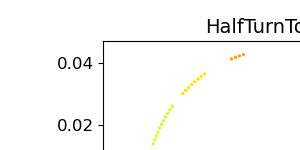

In [25]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Differential inductance versus current (Iron-yoke effect) - IMPORT FROM ROXIE

<IPython.core.display.Javascript object>


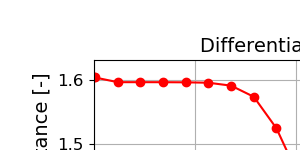

In [26]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software
fL_I = [0, 25.2, 473.94, 922.68, 1371.42, 1820.16, 2268.9, 2717.64, 3166.38, 3615.12, 4063.86, 4512.6, 4961.34, 5410.08, 5858.82, 6307.56, 6756.3, 7205.04, 7653.78, 8102.52, 8551.26, 9000 ]
fL_L = [1.6039096732005, 1.6039096732005, 1.59658499676922, 1.5965846496856, 1.59654395801728, 1.5963424630292, 1.59570402603515, 1.59110844732943, 1.57365116213805, 1.52412106659407, 1.44717955060048, 1.37741778031827, 1.30039802028159, 1.22971327696782, 1.17991389634388, 1.14550265936381, 1.11848749443219, 1.09631224470895, 1.08138526639902, 1.07132755517433, 1.06247444166065, 1.05484498437456 ]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Time Vector Definition

<IPython.core.display.Javascript object>


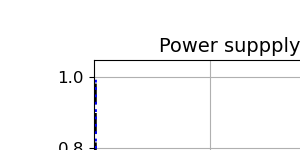

In [27]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [tStart, 5E-4, 0, 5E-4, 5E-4, 0.5, 0.501, 0.001, 1]

# Plot
f = plt.figure(figsize=(7.5,5))
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

# Options - Change something only if you know what you're doing

In [28]:
# Field-Map Files Options
Iref = Iref # Note: slightly different from I_nominal=5750 A
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 2
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 2
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 1
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.005
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 1
MinMaxXY_MTF = [-60, 60, -60, 60]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [29]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [30]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [31]:
# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()

# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
    RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH,
    s_ins_QH,  type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m)

# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)

# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)

# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)

# Visualize the defined variables

In [32]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

### "Inputs" variables ###
Initial temperature [K]
T00 1.9
Magnetic length [m]
l_magnet 9.45
Initial current [A]
I00 5750
Define the coil section where each group of cables is located
GroupToCoilSection [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Polarity of the current in each group of strands
polarities_inGroup [1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1]
Number of half-turns in each group
nT [ 9 11  8  4  9 11  8  4  9 11  8  4  9 11  8  4]
Number of strands in each cable belonging to a particular group
nStrands_inGroup [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
length of each half turn [m] (default=l_magnet)
l_mag_inGroup [9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45, 9.45]
strand diameter [m]
ds_inGroup [0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477, 0.0006477]
fraction of supercondu

# Write the LEDET input file

In [33]:
nameFileLEDET = nameMagnet + '_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

Preliminary consistency check was successful! -  MBX_0.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-26 15:34:33.181809
New file MBX_0.xlsx generated.


# Persistent Currents


<IPython.core.display.Javascript object>


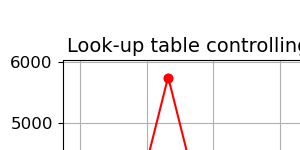

Preliminary consistency check was successful! -  MBX_200.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-26 15:34:33.933857
New file MBX_200.xlsx generated.


In [34]:
# This cell writes an input file for simulating a powering cycle

# Define input parameters 
I00 = 5750 # Amplitude for current. Default nominal current
I_PC_LUT = [0, 0, I00, I00, 0, 0, I00, I00, 0] # Current LUT
dIdt = 17.453    # Current ramp rate 
timeStep = 0.01  # Coarse time step - works 

# Write input file to LEDET
nameFileLEDET_PS = nameMagnet + '_200' + '.xlsx'
PS_paramLEDET = deepcopy(paramLEDET)
PS_paramLEDET.localsParser(locals())
PS_paramLEDET.preparePersistentCurrents(I_PC_LUT, dIdt, timeStep)
PS_paramLEDET.writeFileLEDET(nameFileLEDET_PS)